# Notebook 2: Bigram Language Model (Baseline)

The simplest possible neural language model: predict the next token using **only** the current token.

This model has no concept of position, no attention, no context beyond the single previous token. It serves as our **baseline** for the reverse ablation study. Every component we add in later notebooks should beat this.

## The Embedding Space Perspective

In Notebook 1, we built a tokenizer that defines **which concepts get their own embedding vector**. Now we give those vectors actual values and see what a model can learn.

The bigram model is the most extreme case:
- The entire model is a **single embedding table** of shape `(vocab_size, vocab_size)`
- Row `i` of this table = the model's prediction for "what comes after token `i`?"
- There is no hidden representation, no learned features, no context
- Each token maps to **one fixed probability distribution** over next tokens, regardless of what came before it

In embedding space terms: every token has a single, static "prediction vector." The word `be` always predicts the same next-token distribution whether it appears in "to **be** or not" or "I will **be** there." This is the fundamental limitation we'll break in Notebook 3.

## Outline
1. Load data and tokenizer
2. Build the data pipeline (how text becomes training examples)
3. Implement the Bigram model
4. Training loop
5. Visualize what the model learned
6. Evaluate, generate text, and record baseline metrics

In [1]:
import os
import re
import json
import math
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

print(f"PyTorch version: {torch.__version__}")
print(f"Device: cpu (intentional for learning)")

PyTorch version: 2.10.0
Device: cpu (intentional for learning)


## 1. Load Data and Tokenizer

We reuse the BPE tokenizer from Notebook 1. This is the same tokenizer — same vocab, same merges — so our token IDs are consistent across notebooks.

**Important fix from Notebook 1:** The tokenizer uses `_pre_tokenize` to split text into words before applying merges. This makes encoding fast (seconds instead of hanging).

In [2]:
# --- BPE Tokenizer (from Notebook 1, with fast encode) ---

def _pre_tokenize(text):
    """Split text into chunks using GPT-2-style regex."""
    pattern = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\w+| ?[^\s\w]+|\s+""")
    chunks = pattern.findall(text)
    return [chunk.encode("utf-8") for chunk in chunks]

def merge_pair(token_ids, pair, new_id):
    """Replace all occurrences of `pair` in `token_ids` with `new_id`."""
    merged = []
    i = 0
    while i < len(token_ids):
        if i < len(token_ids) - 1 and (token_ids[i], token_ids[i + 1]) == pair:
            merged.append(new_id)
            i += 2
        else:
            merged.append(token_ids[i])
            i += 1
    return merged

class BPETokenizer:
    """Byte-Pair Encoding tokenizer."""
    def __init__(self, merges, vocab):
        self.merges = merges
        self.vocab = vocab
        self.merge_map = {pair: new_id for pair, new_id in merges}

    @property
    def vocab_size(self):
        return len(self.vocab)

    def encode(self, text):
        """Encode text to token IDs (fast: pre-tokenizes into words first)."""
        chunks = _pre_tokenize(text)
        all_ids = []
        for chunk in chunks:
            word = list(chunk)
            for pair, new_id in self.merges:
                word = merge_pair(word, pair, new_id)
            all_ids.extend(word)
        return all_ids

    def decode(self, token_ids):
        """Decode token IDs back to text."""
        byte_sequence = b"".join(self.vocab[id] for id in token_ids)
        return byte_sequence.decode("utf-8", errors="replace")

    @classmethod
    def load(cls, path):
        with open(path, "r") as f:
            data = json.load(f)
        merges = [((a, b), new_id) for [a, b], new_id in data["merges"]]
        vocab = {int(k): bytes(v) for k, v in data["vocab"].items()}
        return cls(merges, vocab)

print("BPETokenizer loaded (with fast pre-tokenized encode).")

BPETokenizer loaded (with fast pre-tokenized encode).


In [3]:
# Load tokenizer and data
tokenizer = BPETokenizer.load(os.path.join("..", "data", "bpe_tokenizer.json"))
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

with open(os.path.join("..", "data", "tinyshakespeare.txt"), "r") as f:
    text = f.read()

# Encode the full dataset
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
print(f"Encoded dataset: {len(data):,} tokens")
print(f"Compression: {len(text):,} chars -> {len(data):,} tokens ({len(text)/len(data):.2f}x)")

# Show a sample
sample_ids = data[:20].tolist()
sample_tokens = [tokenizer.vocab[id].decode('utf-8', errors='replace') for id in sample_ids]
print(f"\nFirst 20 tokens: {sample_tokens}")
print(f"First 20 IDs:    {sample_ids}")

Tokenizer vocab size: 512
Encoded dataset: 568,603 tokens
Compression: 1,115,394 chars -> 568,603 tokens (1.96x)

First 20 tokens: ['F', 'ir', 'st', ' C', 'it', 'i', 'z', 'en', ':', '\n', 'B', 'e', 'f', 'ore', ' we', ' p', 'ro', 'ce', 'ed', ' an']
First 20 IDs:    [70, 314, 296, 421, 275, 105, 122, 280, 58, 10, 66, 101, 102, 370, 332, 290, 371, 309, 316, 404]


## 2. Data Pipeline: How Text Becomes Training Examples

A language model learns to predict the **next token** given previous tokens. To train it, we need (input, target) pairs where the target is the input shifted by one position.

### The Shifting Trick

Given a sequence `[A, B, C, D, E]`, we create:
- **Input:**  `[A, B, C, D]`
- **Target:** `[B, C, D, E]`

At each position `i`, the model's job is: given `input[:i+1]`, predict `target[i]`.

This means a single sequence of length `T` gives us `T` training examples simultaneously:
- Position 0: given `[A]`, predict `B`
- Position 1: given `[A, B]`, predict `C`
- Position 2: given `[A, B, C]`, predict `D`
- Position 3: given `[A, B, C, D]`, predict `E`

(The bigram model ignores all context and only uses the current token, but we set up the data pipeline correctly for future models.)

### Why `block_size`?

We can't feed the entire 568K-token sequence at once — that would require an impossibly large attention matrix ($568K \times 568K$). Instead, we sample random chunks of length `block_size`. This is the model's **context window** — the maximum number of tokens it can see at once.

In [4]:
# Train/val split (90/10)
split_idx = int(0.9 * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]
print(f"Train tokens: {len(train_data):,}")
print(f"Val tokens:   {len(val_data):,}")
print(f"Split ratio:  {len(train_data)/len(data):.1%} / {len(val_data)/len(data):.1%}")

Train tokens: 511,742
Val tokens:   56,861
Split ratio:  90.0% / 10.0%


In [5]:
# Hyperparameters
block_size = 64    # context length (number of tokens the model sees)
batch_size = 32    # number of sequences processed in parallel

def get_batch(split):
    """
    Sample a random batch of (input, target) sequences.
    
    For language modeling, the target is the input shifted by one position:
    - Input:  [t0, t1, t2, ..., t_{n-1}]
    - Target: [t1, t2, t3, ..., t_n]
    
    So at each position i, the model should predict target[i] given input[:i+1].
    """
    d = train_data if split == "train" else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i + block_size] for i in ix])
    y = torch.stack([d[i + 1:i + block_size + 1] for i in ix])
    return x, y

# Test it
xb, yb = get_batch("train")
print(f"Input shape:  {xb.shape}  (batch_size={batch_size}, block_size={block_size})")
print(f"Target shape: {yb.shape}")

Input shape:  torch.Size([32, 64])  (batch_size=32, block_size=64)
Target shape: torch.Size([32, 64])


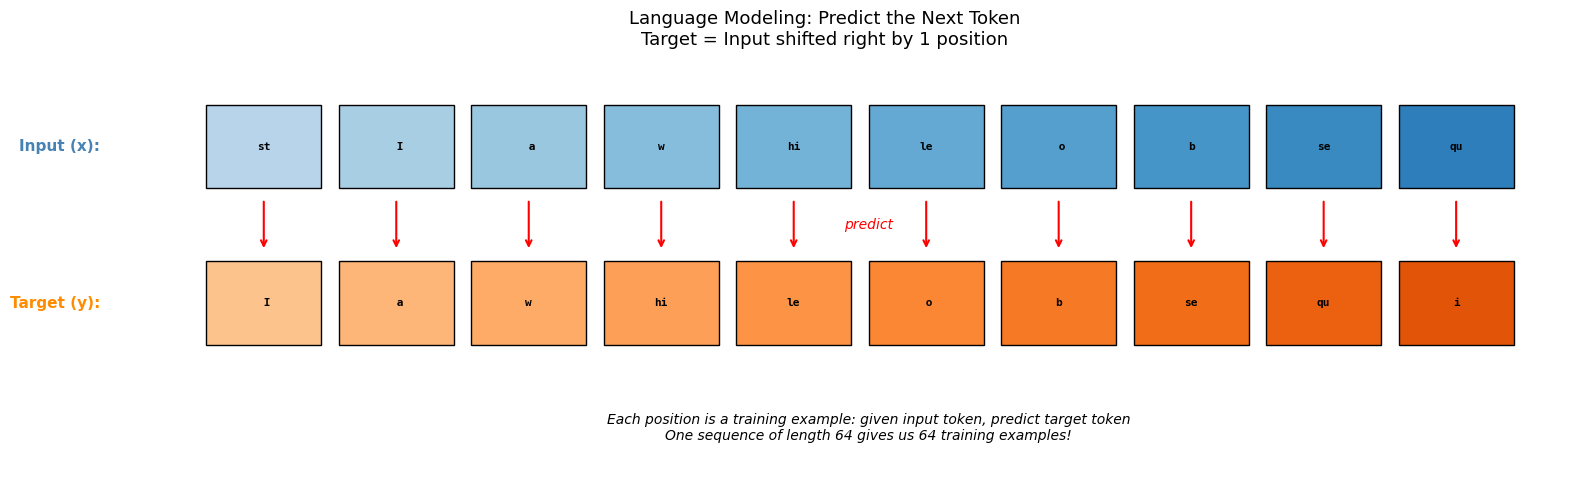

Training examples from this sequence:
  Position 0: ['st'] -> predict ' I'
  Position 1: ['st', ' I'] -> predict ' a'
  Position 2: ['st', ' I', ' a'] -> predict 'w'
  Position 3: ['st', ' I', ' a', 'w'] -> predict 'hi'
  Position 4: ['st', ' I', ' a', 'w', 'hi'] -> predict 'le'
  Position 5: ['st', ' I', ' a', 'w', 'hi', 'le'] -> predict ' o'
  ... (64 examples total from this one sequence)


In [6]:
# Visualize: how input/target pairs work

# Take one sequence from the batch and show the shifting
seq_len_show = 10  # show first 10 positions
x_show = xb[0, :seq_len_show].tolist()
y_show = yb[0, :seq_len_show].tolist()

x_tokens = [tokenizer.vocab[id].decode('utf-8', errors='replace') for id in x_show]
y_tokens = [tokenizer.vocab[id].decode('utf-8', errors='replace') for id in y_show]

fig, ax = plt.subplots(figsize=(16, 5))

colors_input = plt.cm.Blues(np.linspace(0.3, 0.7, seq_len_show))
colors_target = plt.cm.Oranges(np.linspace(0.3, 0.7, seq_len_show))

# Draw input row
for i in range(seq_len_show):
    display = repr(x_tokens[i])[1:-1]
    rect = plt.Rectangle((i * 1.5, 2), 1.3, 0.8,
                          facecolor=colors_input[i], edgecolor='black', linewidth=1)
    ax.add_patch(rect)
    ax.text(i * 1.5 + 0.65, 2.4, display, ha='center', va='center',
            fontsize=8, fontfamily='monospace', fontweight='bold')

# Draw target row
for i in range(seq_len_show):
    display = repr(y_tokens[i])[1:-1]
    rect = plt.Rectangle((i * 1.5, 0.5), 1.3, 0.8,
                          facecolor=colors_target[i], edgecolor='black', linewidth=1)
    ax.add_patch(rect)
    ax.text(i * 1.5 + 0.65, 0.9, display, ha='center', va='center',
            fontsize=8, fontfamily='monospace', fontweight='bold')

# Draw arrows showing the prediction task
for i in range(seq_len_show):
    ax.annotate('', xy=(i * 1.5 + 0.65, 1.4), xytext=(i * 1.5 + 0.65, 1.9),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

# Labels
ax.text(-1.2, 2.4, 'Input (x):', ha='right', va='center', fontsize=11, fontweight='bold', color='steelblue')
ax.text(-1.2, 0.9, 'Target (y):', ha='right', va='center', fontsize=11, fontweight='bold', color='darkorange')
ax.text(seq_len_show * 1.5 / 2, 1.65, 'predict', ha='center', va='center',
        fontsize=10, color='red', fontstyle='italic')

# Training examples annotation
ax.text(seq_len_show * 1.5 / 2, -0.3,
        f'Each position is a training example: given input token, predict target token\n'
        f'One sequence of length {block_size} gives us {block_size} training examples!',
        ha='center', va='center', fontsize=10, fontstyle='italic')

ax.set_xlim(-1.5, seq_len_show * 1.5 + 0.5)
ax.set_ylim(-0.8, 3.3)
ax.set_title('Language Modeling: Predict the Next Token\n'
             'Target = Input shifted right by 1 position', fontsize=13)
ax.axis('off')
plt.tight_layout()
plt.show()

# Also show the actual training examples this creates
print("Training examples from this sequence:")
for i in range(min(6, seq_len_show)):
    context = x_tokens[:i+1]
    target = y_tokens[i]
    print(f"  Position {i}: {context} -> predict {repr(target)}")
print(f"  ... ({block_size} examples total from this one sequence)")

## 3. The Bigram Model

This is the simplest possible neural language model. The entire architecture is:

```
token_id  -->  [Embedding Table]  -->  logits over vocab  -->  softmax  -->  probabilities
   (int)       (vocab x vocab)        (512 numbers)                        (512 numbers, sum=1)
```

That's it. **The embedding table IS the model.** There is no hidden layer.

### What Does This Mean in Embedding Space?

The embedding table has shape `(vocab_size, vocab_size)` = `(512, 512)` = **262,144 parameters**.

- **Row `i`** contains the model's answer to: "Given that the current token is `i`, what's the probability distribution over the next token?"
- Each row is a vector of 512 logits. After softmax, these become probabilities.
- The model learns a **transition matrix** — exactly like a Markov chain.

### The Critical Limitation

Since each token maps to exactly **one row** of the table, the model has:
- **No position awareness**: Token `the` predicts the same next token whether it's at position 0 or position 63
- **No context**: Token `be` predicts the same distribution whether the context is "to **be** or not" or "will **be** there"
- **No composition**: The model can't combine information from multiple tokens

This is what makes it a useful baseline — it tells us: *how much can you learn from single-token statistics alone?*

In [7]:
class BigramModel(nn.Module):
    """
    Bigram language model.
    
    Architecture: token -> embedding lookup -> logits
    That's it. The embedding table IS the model.
    
    The embedding has shape (vocab_size, vocab_size):
    - Row i = logits for P(next_token | current_token = i)
    - This is equivalent to learning a Markov chain transition matrix
    """
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        """
        Args:
            idx: (B, T) tensor of token indices
            targets: (B, T) tensor of target token indices (optional)
        Returns:
            logits: (B, T, vocab_size) - predictions for each position
            loss: scalar cross-entropy loss (if targets provided)
        """
        logits = self.token_embedding(idx)  # (B, T) -> (B, T, vocab_size)
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B * T, C), targets.view(B * T))
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        """
        Generate new tokens autoregressively.
        For bigram: we only need the LAST token to predict the next one.
        """
        for _ in range(max_new_tokens):
            logits, _ = self(idx)
            logits = logits[:, -1, :]  # (B, vocab_size) - last position only
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # (B, 1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx


# Create model
model = BigramModel(tokenizer.vocab_size)
num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")
print(f"  = vocab_size x vocab_size = {tokenizer.vocab_size} x {tokenizer.vocab_size} = {tokenizer.vocab_size**2:,}")
print(f"\nThe entire model is a single {tokenizer.vocab_size}x{tokenizer.vocab_size} lookup table.")
print(f"No hidden layers, no attention, no position encoding.")

Model parameters: 262,144
  = vocab_size x vocab_size = 512 x 512 = 262,144

The entire model is a single 512x512 lookup table.
No hidden layers, no attention, no position encoding.


In [8]:
# Sanity check: untrained model should have loss ≈ -ln(1/vocab_size)
xb, yb = get_batch("train")
logits, loss = model(xb, yb)

expected_loss = math.log(tokenizer.vocab_size)
print(f"Untrained loss:  {loss.item():.4f}")
print(f"Expected random: {expected_loss:.4f}  = -ln(1/{tokenizer.vocab_size}) = ln({tokenizer.vocab_size})")
print(f"\nThese should be close. An untrained model assigns roughly equal probability")
print(f"to all {tokenizer.vocab_size} tokens, so cross-entropy ≈ ln(vocab_size).")
print(f"\nAfter training, the model will learn which tokens are likely to follow which,")
print(f"and the loss will drop significantly.")

Untrained loss:  6.6927
Expected random: 6.2383  = -ln(1/512) = ln(512)

These should be close. An untrained model assigns roughly equal probability
to all 512 tokens, so cross-entropy ≈ ln(vocab_size).

After training, the model will learn which tokens are likely to follow which,
and the loss will drop significantly.


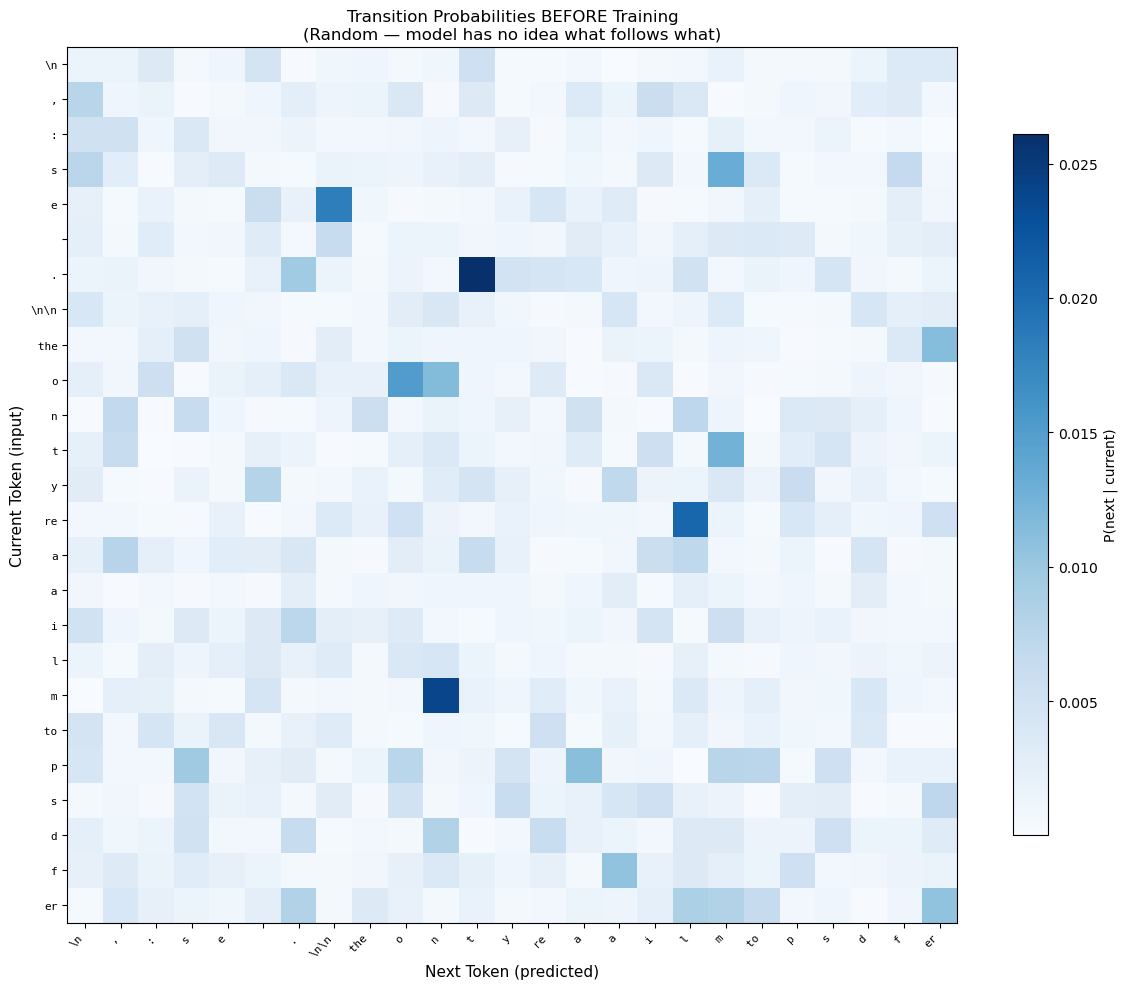

Before training: probabilities are roughly uniform (~0.0020 each).
The model assigns nearly equal probability to all 512 possible next tokens.
After training, we'll see clear structure emerge in this matrix.


In [9]:
# Visualize: what the embedding table looks like BEFORE training
# It's random noise — the model has no idea which tokens follow which

# Get the raw weights
with torch.no_grad():
    W = model.token_embedding.weight.clone()  # (vocab_size, vocab_size)
    probs_before = F.softmax(W, dim=-1)  # convert to probabilities

# Pick some interesting tokens to visualize
# Find the most common tokens in our data
token_counts = Counter(data.tolist())
top_token_ids = [id for id, _ in token_counts.most_common(25)]
top_token_labels = [repr(tokenizer.vocab[id].decode('utf-8', errors='replace'))[1:-1] for id in top_token_ids]

fig, ax = plt.subplots(figsize=(12, 10))

# Show transition probabilities for top 25 tokens
prob_matrix = probs_before[top_token_ids][:, top_token_ids].numpy()
im = ax.imshow(prob_matrix, cmap='Blues', aspect='auto')

ax.set_xticks(range(len(top_token_labels)))
ax.set_yticks(range(len(top_token_labels)))
ax.set_xticklabels(top_token_labels, rotation=45, ha='right', fontsize=8, fontfamily='monospace')
ax.set_yticklabels(top_token_labels, fontsize=8, fontfamily='monospace')
ax.set_xlabel('Next Token (predicted)', fontsize=11)
ax.set_ylabel('Current Token (input)', fontsize=11)
ax.set_title('Transition Probabilities BEFORE Training\n'
             '(Random — model has no idea what follows what)', fontsize=12)
plt.colorbar(im, ax=ax, label='P(next | current)', shrink=0.8)
plt.tight_layout()
plt.show()

print(f"Before training: probabilities are roughly uniform (~{1/tokenizer.vocab_size:.4f} each).")
print(f"The model assigns nearly equal probability to all {tokenizer.vocab_size} possible next tokens.")
print(f"After training, we'll see clear structure emerge in this matrix.")

## 4. Training Loop

### What Does Training Do?

Training adjusts the 262K parameters (the embedding table) to minimize **cross-entropy loss**:

$$\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \log P(\text{target}_i \mid \text{input}_i)$$

In plain English: the model looks at each token, makes a prediction about the next token, and gets punished when it's wrong. The punishment is proportional to how confident it was in the wrong answer.

- **Loss = ln(512) ≈ 6.24**: Model is guessing randomly (no knowledge)
- **Loss ≈ 4.0**: Model has learned basic token frequencies
- **Loss ≈ 3.0**: Model has learned common bigram patterns
- **Loss < 2.0**: Would require context (impossible for bigram model)

### Optimizer: AdamW

We use AdamW, the standard optimizer for training neural networks. It adapts the learning rate per-parameter based on gradient history. The key hyperparameter is the learning rate — too high and training is unstable, too low and it's slow.

In [10]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    """Estimate train and val loss by averaging over many batches."""
    model.eval()
    losses = {}
    for split in ["train", "val"]:
        total = 0.0
        for _ in range(eval_iters):
            xb, yb = get_batch(split)
            _, loss = model(xb, yb)
            total += loss.item()
        losses[split] = total / eval_iters
    model.train()
    return losses

In [11]:
# Training hyperparameters
learning_rate = 1e-3
max_steps = 10000
eval_interval = 500

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
print(f"Training bigram model for {max_steps:,} steps...")
print(f"  batch_size={batch_size}, block_size={block_size}, lr={learning_rate}")
print(f"  Each step processes {batch_size * block_size:,} tokens")
print(f"\n{'Step':>6} {'Train Loss':>12} {'Val Loss':>12}")
print("-" * 32)

# Track losses for plotting
step_losses = []  # (step, train_loss) at every step
eval_losses = []  # (step, train_loss, val_loss) at eval intervals

for step in range(max_steps):
    # Evaluate periodically
    if step % eval_interval == 0 or step == max_steps - 1:
        losses = estimate_loss(model)
        eval_losses.append((step, losses["train"], losses["val"]))
        print(f"{step:>6} {losses['train']:>12.4f} {losses['val']:>12.4f}")
    
    # Training step
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    step_losses.append((step, loss.item()))

final_train = eval_losses[-1][1]
final_val = eval_losses[-1][2]
print(f"\nFinal train loss: {final_train:.4f}")
print(f"Final val loss:   {final_val:.4f}")
print(f"Improvement from random: {math.log(tokenizer.vocab_size):.2f} -> {final_val:.2f} "
      f"({(1 - final_val/math.log(tokenizer.vocab_size))*100:.0f}% reduction)")

Training bigram model for 10,000 steps...
  batch_size=32, block_size=64, lr=0.001
  Each step processes 2,048 tokens

  Step   Train Loss     Val Loss
--------------------------------
     0       6.7026       6.7013
   500       6.1143       6.1281
  1000       5.5903       5.6231
  1500       5.1467       5.1936
  2000       4.7721       4.8367
  2500       4.4733       4.5537
  3000       4.2335       4.3299
  3500       4.0504       4.1585
  4000       3.9142       4.0329
  4500       3.7988       3.9395
  5000       3.7137       3.8700
  5500       3.6485       3.8188
  6000       3.6092       3.7798
  6500       3.5723       3.7525
  7000       3.5434       3.7353
  7500       3.5311       3.7169
  8000       3.5040       3.6990
  8500       3.4850       3.6986
  9000       3.4850       3.6924
  9500       3.4760       3.6856
  9999       3.4665       3.6823

Final train loss: 3.4665
Final val loss:   3.6823
Improvement from random: 6.24 -> 3.68 (41% reduction)


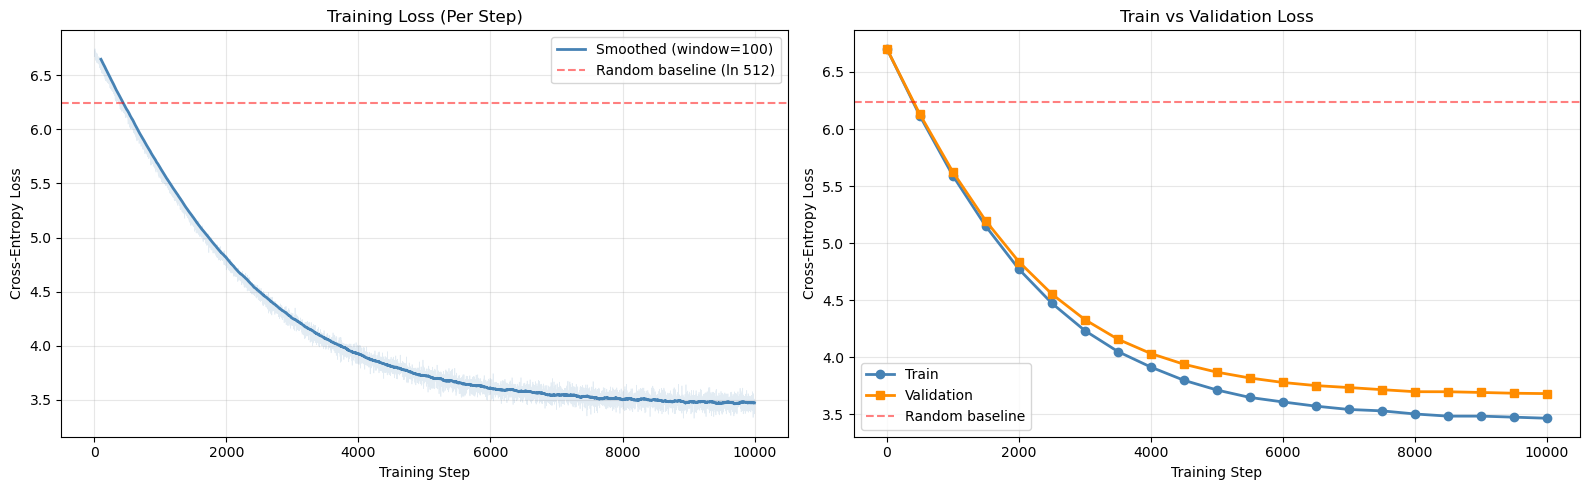

Left: raw per-step loss is noisy (each batch is random), but the trend is clear.
Right: train and val losses track closely — no overfitting (the model is too simple to overfit).

The loss drops fast in the first ~5000 steps as the model learns basic token frequencies,
then plateaus. This plateau is the bigram ceiling — you can't go lower without context.


In [20]:
# Visualize: training loss curve

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Plot 1: Per-step training loss (raw) ---
ax = axes[0]
steps_arr = [s for s, _ in step_losses]
losses_arr = [l for _, l in step_losses]

# Plot raw loss (transparent) and smoothed
ax.plot(steps_arr, losses_arr, alpha=0.15, color='steelblue', linewidth=0.5)

# Smoothed (rolling average)
window = 100
if len(losses_arr) > window:
    smoothed = np.convolve(losses_arr, np.ones(window)/window, mode='valid')
    ax.plot(steps_arr[window-1:], smoothed, color='steelblue', linewidth=2, label=f'Smoothed (window={window})')

# Random baseline
ax.axhline(y=math.log(tokenizer.vocab_size), color='red', linestyle='--', alpha=0.5, label=f'Random baseline (ln {tokenizer.vocab_size})')

ax.set_xlabel('Training Step')
ax.set_ylabel('Cross-Entropy Loss')
ax.set_title('Training Loss (Per Step)')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Plot 2: Eval losses (train vs val) ---
ax = axes[1]
eval_steps = [s for s, _, _ in eval_losses]
eval_train = [t for _, t, _ in eval_losses]
eval_val = [v for _, _, v in eval_losses]

ax.plot(eval_steps, eval_train, 'o-', color='steelblue', linewidth=2, markersize=6, label='Train')
ax.plot(eval_steps, eval_val, 's-', color='darkorange', linewidth=2, markersize=6, label='Validation')
ax.axhline(y=math.log(tokenizer.vocab_size), color='red', linestyle='--', alpha=0.5, label='Random baseline')

ax.set_xlabel('Training Step')
ax.set_ylabel('Cross-Entropy Loss')
ax.set_title('Train vs Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Left: raw per-step loss is noisy (each batch is random), but the trend is clear.")
print(f"Right: train and val losses track closely — no overfitting (the model is too simple to overfit).")
print(f"\nThe loss drops fast in the first ~5000 steps as the model learns basic token frequencies,")
print(f"then plateaus. This plateau is the bigram ceiling — you can't go lower without context.")

## 5. What Did the Model Learn?

The trained embedding table now contains the model's learned transition probabilities. Let's visualize what it discovered about Shakespeare's token patterns.

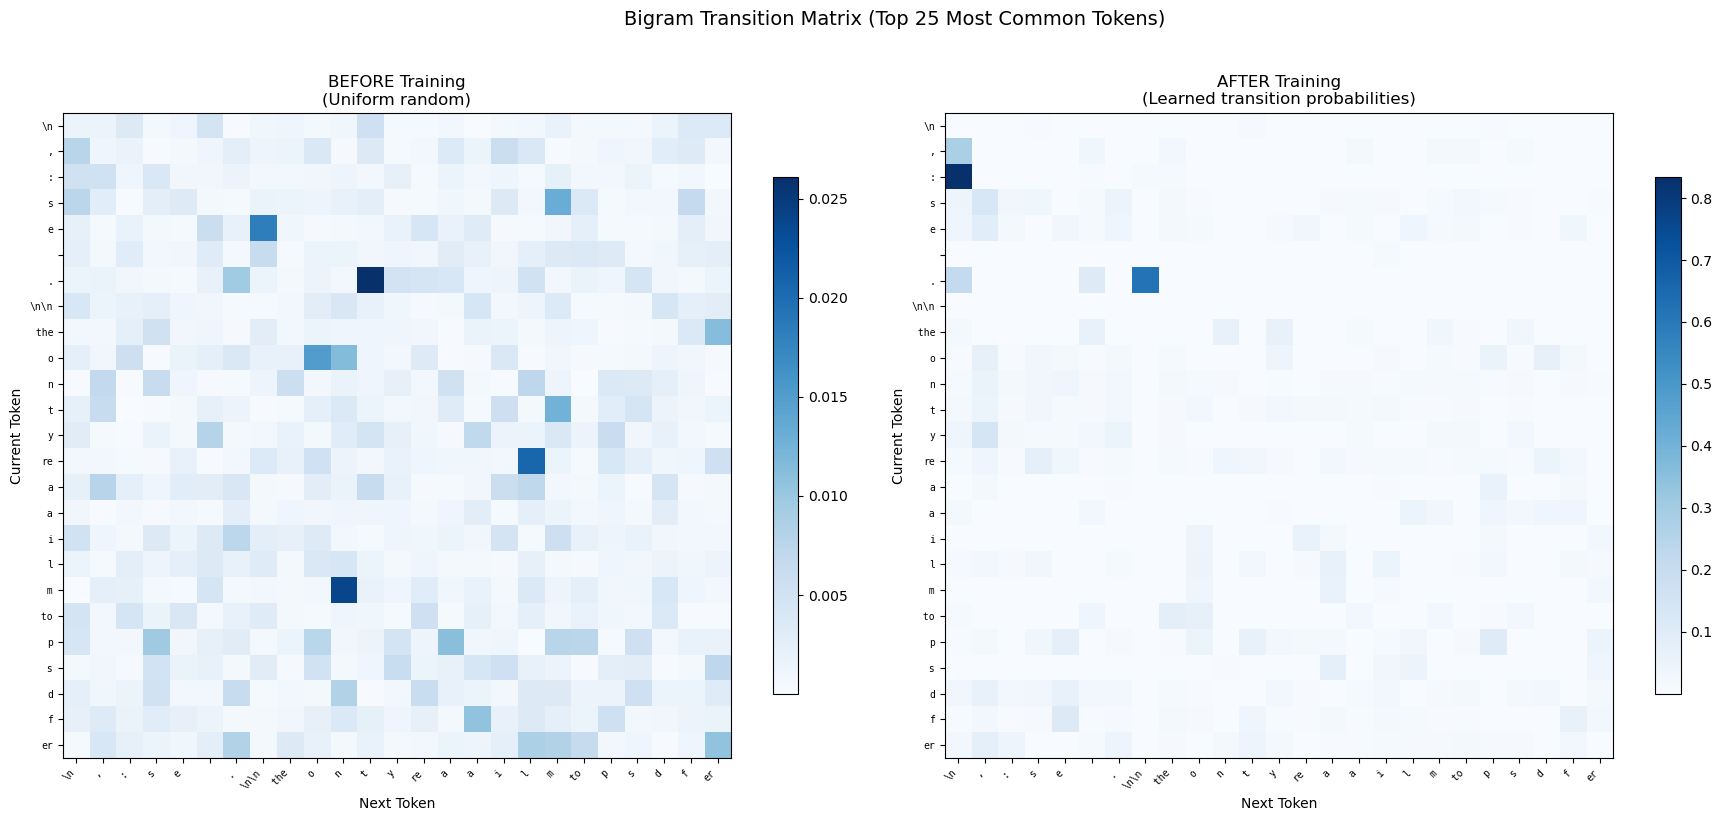

Before: flat/uniform — the model knows nothing.
After: clear structure — bright spots show which tokens commonly follow which.
Each row is one token's learned prediction vector in the embedding table.


In [13]:
# Visualize: transition probabilities AFTER training (compare with before)

with torch.no_grad():
    W_trained = model.token_embedding.weight.clone()
    probs_after = F.softmax(W_trained, dim=-1)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Before training
ax = axes[0]
prob_before = probs_before[top_token_ids][:, top_token_ids].numpy()
im0 = ax.imshow(prob_before, cmap='Blues', aspect='auto')
ax.set_xticks(range(len(top_token_labels)))
ax.set_yticks(range(len(top_token_labels)))
ax.set_xticklabels(top_token_labels, rotation=45, ha='right', fontsize=7, fontfamily='monospace')
ax.set_yticklabels(top_token_labels, fontsize=7, fontfamily='monospace')
ax.set_xlabel('Next Token')
ax.set_ylabel('Current Token')
ax.set_title('BEFORE Training\n(Uniform random)', fontsize=12)
plt.colorbar(im0, ax=ax, shrink=0.8)

# After training
ax = axes[1]
prob_after = probs_after[top_token_ids][:, top_token_ids].numpy()
im1 = ax.imshow(prob_after, cmap='Blues', aspect='auto')
ax.set_xticks(range(len(top_token_labels)))
ax.set_yticks(range(len(top_token_labels)))
ax.set_xticklabels(top_token_labels, rotation=45, ha='right', fontsize=7, fontfamily='monospace')
ax.set_yticklabels(top_token_labels, fontsize=7, fontfamily='monospace')
ax.set_xlabel('Next Token')
ax.set_ylabel('Current Token')
ax.set_title('AFTER Training\n(Learned transition probabilities)', fontsize=12)
plt.colorbar(im1, ax=ax, shrink=0.8)

plt.suptitle('Bigram Transition Matrix (Top 25 Most Common Tokens)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Before: flat/uniform — the model knows nothing.")
print("After: clear structure — bright spots show which tokens commonly follow which.")
print("Each row is one token's learned prediction vector in the embedding table.")

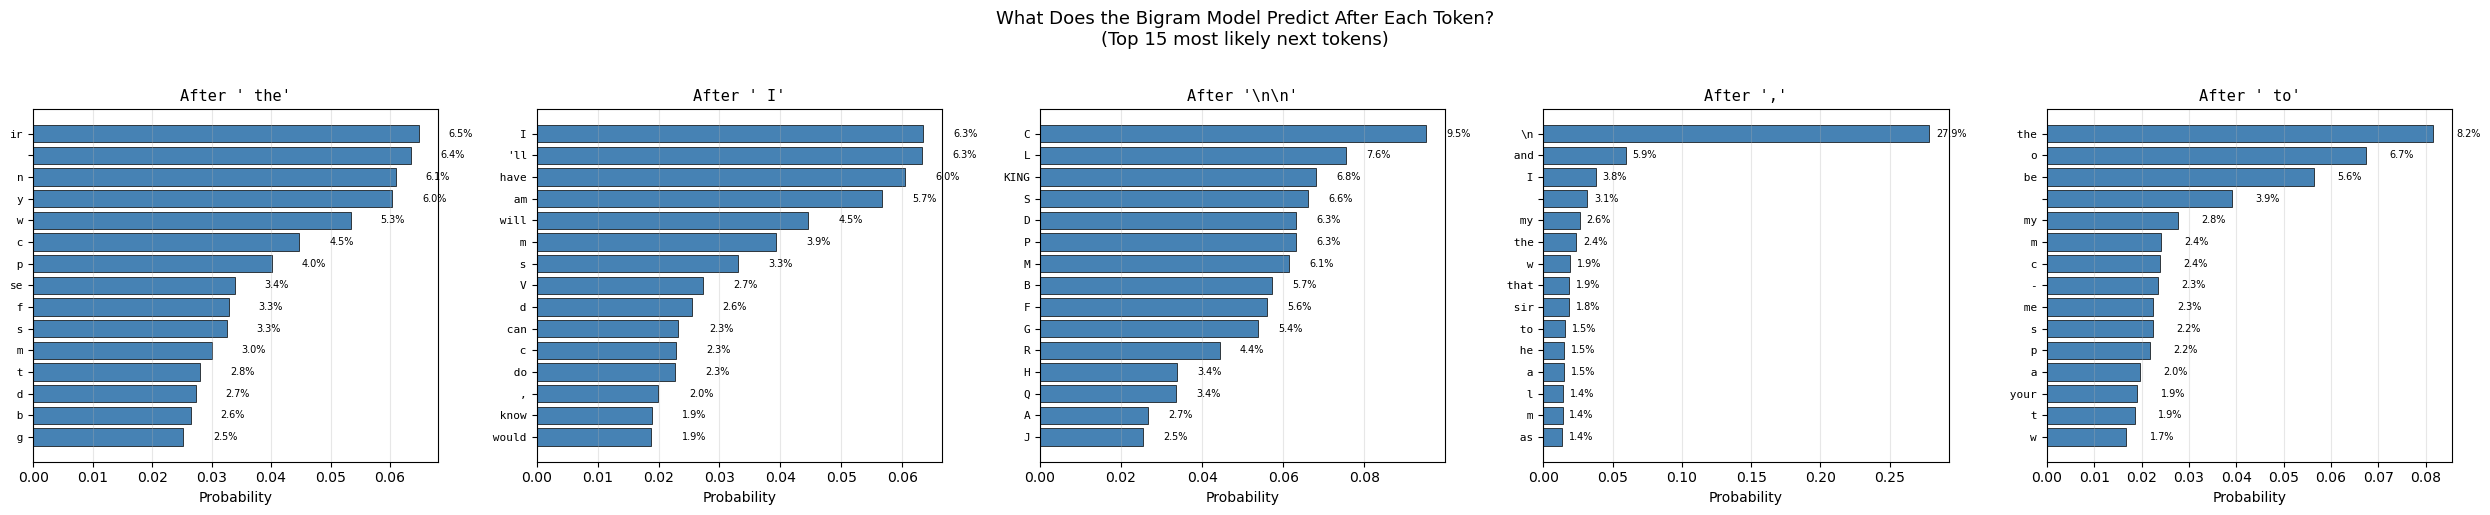

These are the learned "prediction vectors" — each token's row in the embedding table.
Notice: " the" is almost always followed by common words/beginnings.
"\n\n" (double newline) predicts character names — Shakespeare's scene structure!
But the model ALWAYS makes the same prediction for a given token, regardless of context.


In [14]:
# Visualize: next-token probability distributions for specific tokens
# For a few interesting tokens, show what the model thinks comes next

# Pick tokens to analyze
interesting_tokens = [' the', ' I', '\n\n', ',', ' to']
# Find their IDs
token_to_id = {}
for tid, tbytes in tokenizer.vocab.items():
    try:
        tstr = tbytes.decode('utf-8')
        token_to_id[tstr] = tid
    except:
        pass

# Filter to tokens that exist in our vocab
plot_tokens = [(t, token_to_id[t]) for t in interesting_tokens if t in token_to_id]

fig, axes = plt.subplots(1, len(plot_tokens), figsize=(5 * len(plot_tokens), 5))
if len(plot_tokens) == 1:
    axes = [axes]

for ax, (token_str, token_id) in zip(axes, plot_tokens):
    # Get the probability distribution for this token
    with torch.no_grad():
        probs = probs_after[token_id].numpy()
    
    # Top 15 most likely next tokens
    top_k = 15
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]
    top_labels = [repr(tokenizer.vocab[int(idx)].decode('utf-8', errors='replace'))[1:-1] for idx in top_indices]
    
    bars = ax.barh(range(top_k), top_probs[::-1], color='steelblue', edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(top_k))
    ax.set_yticklabels(top_labels[::-1], fontsize=8, fontfamily='monospace')
    ax.set_xlabel('Probability')
    ax.set_title(f'After {repr(token_str)}', fontsize=11, fontfamily='monospace')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Annotate probabilities
    for bar, prob in zip(bars, top_probs[::-1]):
        if prob > 0.01:
            ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                    f'{prob:.1%}', va='center', fontsize=7)

plt.suptitle('What Does the Bigram Model Predict After Each Token?\n'
             '(Top 15 most likely next tokens)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print('These are the learned "prediction vectors" — each token\'s row in the embedding table.')
print('Notice: " the" is almost always followed by common words/beginnings.')
print('"\\n\\n" (double newline) predicts character names — Shakespeare\'s scene structure!')
print('But the model ALWAYS makes the same prediction for a given token, regardless of context.')

The token ' be' appears in many different contexts:
But the bigram model ALWAYS predicts the same distribution after it.



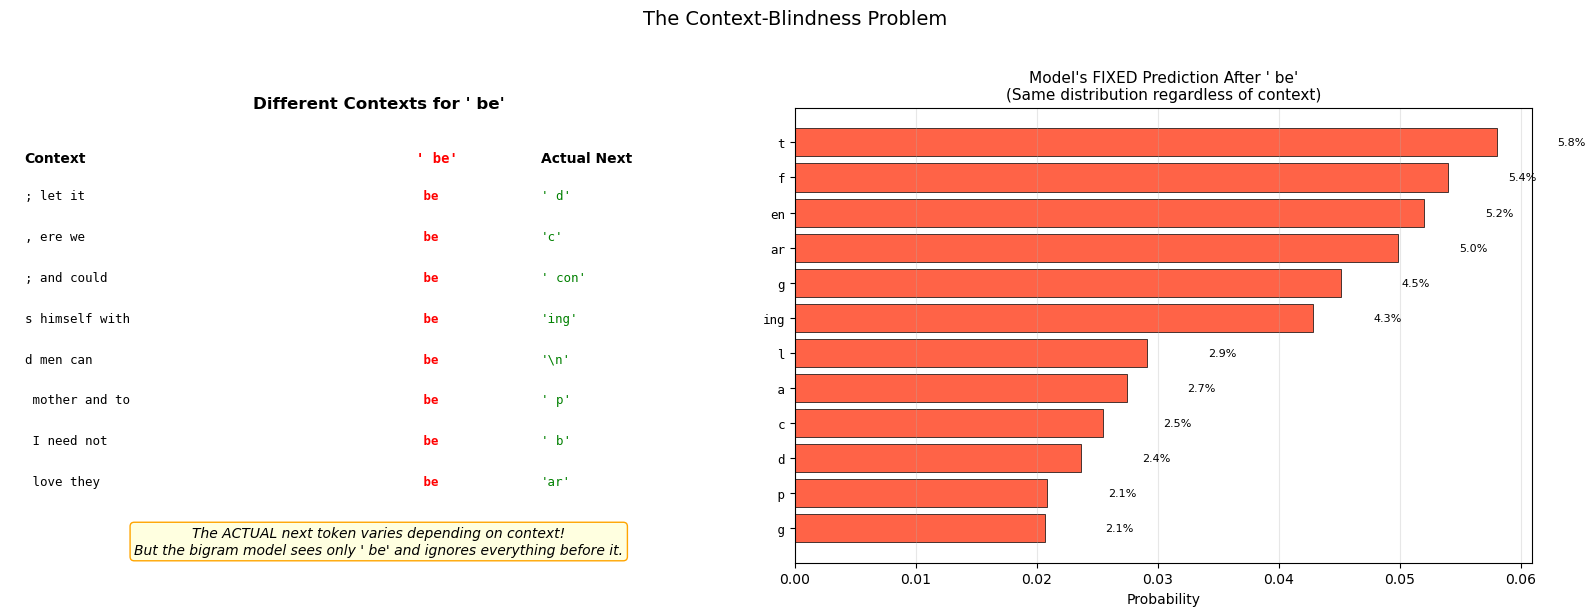


This is WHY we need attention (Notebook 3):
  With attention, the model can look at previous tokens and adjust its prediction.
  Instead of one fixed vector per token, each token gets a CONTEXT-DEPENDENT representation.


In [15]:
# Visualize: the FUNDAMENTAL LIMITATION — no context
# Show that the same token always produces the same prediction,
# even when different contexts should lead to different predictions

# Find a token that appears in different contexts
probe_token = ' be'
if probe_token not in token_to_id:
    # Fallback: try without space
    probe_token = 'be'

probe_id = token_to_id.get(probe_token)

if probe_id is not None:
    # Find occurrences in the data and show surrounding context
    data_list = data.tolist()
    occurrences = []
    for i in range(5, len(data_list) - 5):
        if data_list[i] == probe_id:
            context_before = data_list[max(0, i-4):i]
            actual_next = data_list[i+1] if i+1 < len(data_list) else None
            context_str = tokenizer.decode(context_before)
            next_str = tokenizer.vocab[actual_next].decode('utf-8', errors='replace') if actual_next else '?'
            occurrences.append((context_str, next_str, actual_next))
    
    # Show diverse examples
    print(f"The token {repr(probe_token)} appears in many different contexts:")
    print(f"But the bigram model ALWAYS predicts the same distribution after it.\n")
    
    # Get unique actual next tokens to show diversity
    seen_next = set()
    diverse_examples = []
    for ctx, nxt, nxt_id in occurrences:
        if nxt_id not in seen_next and len(diverse_examples) < 8:
            diverse_examples.append((ctx, nxt, nxt_id))
            seen_next.add(nxt_id)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: show different contexts and what actually follows
    ax = axes[0]
    ax.axis('off')
    y = 0.95
    ax.text(0.5, 1.0, f'Different Contexts for {repr(probe_token)}', ha='center',
            fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.02, 0.88, 'Context', fontsize=10, fontweight='bold', transform=ax.transAxes)
    ax.text(0.55, 0.88, f'{repr(probe_token)}', fontsize=10, fontweight='bold',
            fontfamily='monospace', color='red', transform=ax.transAxes)
    ax.text(0.72, 0.88, 'Actual Next', fontsize=10, fontweight='bold', transform=ax.transAxes)
    
    for i, (ctx, nxt, _) in enumerate(diverse_examples):
        y_pos = 0.80 - i * 0.09
        # Truncate context
        ctx_short = ctx[-20:] if len(ctx) > 20 else ctx
        if len(ctx) > 20:
            ctx_short = '...' + ctx_short
        ax.text(0.02, y_pos, repr(ctx_short)[1:-1], fontsize=9, fontfamily='monospace',
                transform=ax.transAxes)
        ax.text(0.55, y_pos, repr(probe_token)[1:-1], fontsize=9, fontfamily='monospace',
                color='red', fontweight='bold', transform=ax.transAxes)
        ax.text(0.72, y_pos, repr(nxt), fontsize=9, fontfamily='monospace',
                color='green', transform=ax.transAxes)
    
    ax.text(0.5, 0.02, f'The ACTUAL next token varies depending on context!\n'
            f'But the bigram model sees only {repr(probe_token)} and ignores everything before it.',
            ha='center', fontsize=10, fontstyle='italic', transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='orange'))
    
    # Right: the model's FIXED prediction (same for all contexts)
    ax = axes[1]
    with torch.no_grad():
        probs = probs_after[probe_id].numpy()
    top_k = 12
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]
    top_labels = [repr(tokenizer.vocab[int(idx)].decode('utf-8', errors='replace'))[1:-1] for idx in top_indices]
    
    bars = ax.barh(range(top_k), top_probs[::-1], color='tomato', edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(top_k))
    ax.set_yticklabels(top_labels[::-1], fontsize=9, fontfamily='monospace')
    ax.set_xlabel('Probability')
    ax.set_title(f'Model\'s FIXED Prediction After {repr(probe_token)}\n'
                 f'(Same distribution regardless of context)', fontsize=11)
    ax.grid(True, alpha=0.3, axis='x')
    
    for bar, prob in zip(bars, top_probs[::-1]):
        if prob > 0.01:
            ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                    f'{prob:.1%}', va='center', fontsize=8)
    
    plt.suptitle('The Context-Blindness Problem', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\nThis is WHY we need attention (Notebook 3):")
    print(f"  With attention, the model can look at previous tokens and adjust its prediction.")
    print(f"  Instead of one fixed vector per token, each token gets a CONTEXT-DEPENDENT representation.")
else:
    print(f"Token {repr(probe_token)} not found in vocab. Skipping context visualization.")

## 6. Generate Text and Evaluate

Let's see what the trained bigram model actually produces. Remember: it can only use one-token context, so don't expect coherent sentences — but it should produce Shakespeare-*ish* character patterns.

In [16]:
# Generate text from the trained bigram model
print("=" * 60)
print("BIGRAM MODEL — Generated Text")
print("=" * 60)

for i in range(3):
    start = torch.zeros((1, 1), dtype=torch.long)
    generated = model.generate(start, max_new_tokens=200)
    text_out = tokenizer.decode(generated[0].tolist())
    print(f"\n--- Sample {i+1} ---")
    print(text_out)

print("\n" + "=" * 60)
print("Notice: individual tokens look Shakespeare-ish (common words appear),")
print("but there's no coherent structure — words don't form meaningful phrases.")
print("This is because each token is predicted independently, with no context.")
print("\nThis is exactly the floor we need to beat in Notebook 3.")

BIGRAM MODEL — Generated Text

--- Sample 1 ---
 as his good another, I inhere her.

Thound me;
To ans dause:
The come than of hisي of arason were heretandmpse that.

S How lifend meance:
FORSoy hid her; but a
And thene ent; thin, to ext.
To comppo chall, I hathoop, a more
Ay my boot me;
RYounds dil sir,
Which for, but as most cou death can woett.
Th Gր his bill'dst this t5 our had the could be larch thee canie my fooking,
For more in thee; no swhen all like my penfer

--- Sample 2 ---
 5eave the awith man see do.� am seterplearence the ELouse to as a dis ba'With thou of lad, and does to the death;
For 'twesty the whose thenecorioad crave? you:
HUpp.

Y Cors, what afess deves shrightering that, I have s thy�6 that your buchlictionead looky Lord.

BER:
GRExurply in As exppeves. For villowers,
And thou a whoizence:
They were?

LIDY FIAMARIsal: hy'd striarco my lay sh

--- Sample 3 ---
 y thin chilect my wis droud and und of bear proot sugged
And would you, the f could beenged commy.

Pu

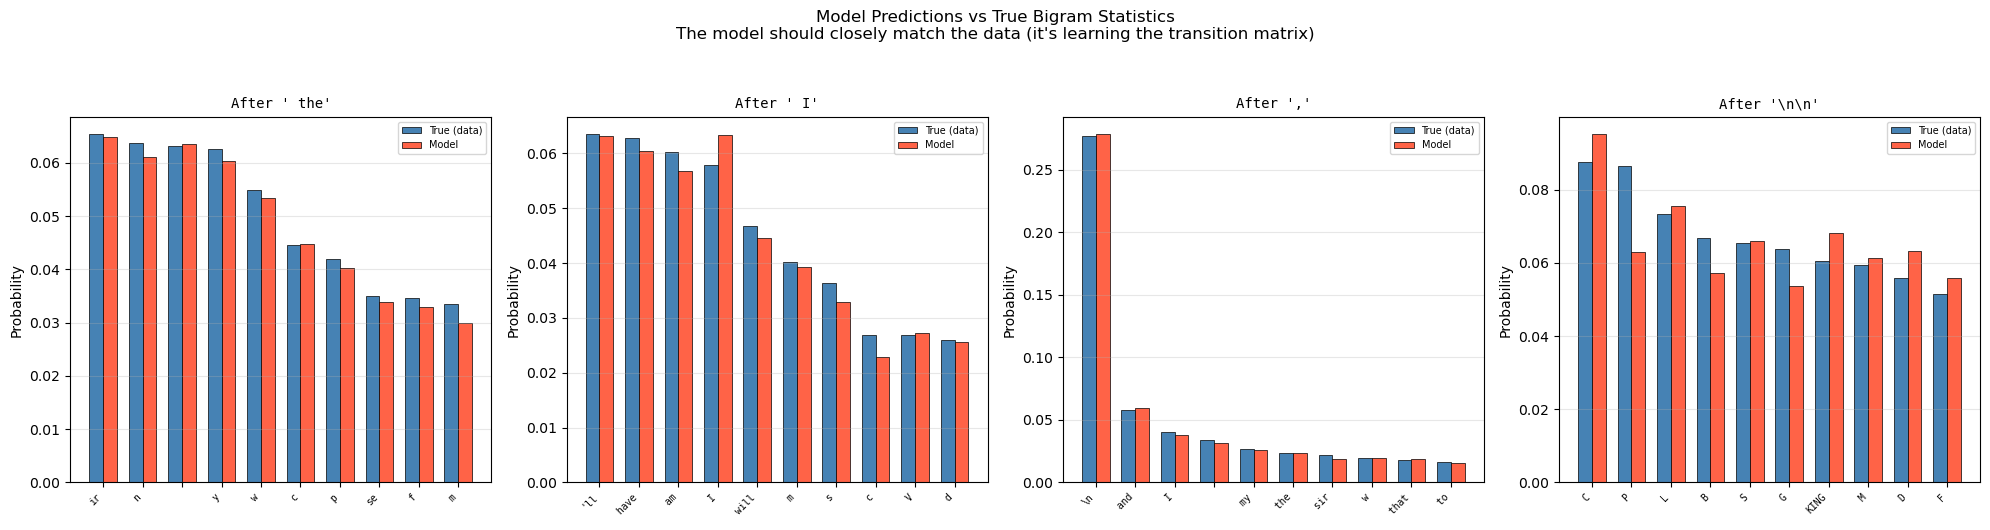

The model's learned probabilities closely match the actual bigram statistics.
This confirms: the bigram model is essentially learning a count-based transition matrix.
A simple counting approach would give the same result — no neural network needed!

The value of the neural network architecture becomes clear in the NEXT notebooks,
where we add components (attention, FFN, layers) that can't be replicated by counting.


In [17]:
# Visualize: compare model's predictions vs actual Shakespeare statistics
# How well does the bigram model match the true bigram statistics?

# Count actual bigram frequencies in the data
data_list = data.tolist()
actual_bigrams = Counter()
for i in range(len(data_list) - 1):
    actual_bigrams[(data_list[i], data_list[i+1])] += 1

# For each current token, get the true conditional distribution
# P_true(next | current) = count(current, next) / count(current)
current_counts = Counter(data_list)

# Compare model vs true for a few tokens
compare_tokens = [t for t in [' the', ' I', ',', '\n\n'] if t in token_to_id]
compare_ids = [token_to_id[t] for t in compare_tokens]

fig, axes = plt.subplots(1, len(compare_tokens), figsize=(5 * len(compare_tokens), 5))
if len(compare_tokens) == 1:
    axes = [axes]

for ax, token_str, token_id in zip(axes, compare_tokens, compare_ids):
    # True distribution
    total = current_counts[token_id]
    true_probs = {}
    for (curr, nxt), count in actual_bigrams.items():
        if curr == token_id:
            true_probs[nxt] = count / total
    
    # Model distribution  
    with torch.no_grad():
        model_probs = probs_after[token_id].numpy()
    
    # Top 10 by true frequency
    top_true = sorted(true_probs.items(), key=lambda x: x[1], reverse=True)[:10]
    top_ids_show = [tid for tid, _ in top_true]
    
    labels = [repr(tokenizer.vocab[tid].decode('utf-8', errors='replace'))[1:-1] for tid in top_ids_show]
    true_vals = [true_probs.get(tid, 0) for tid in top_ids_show]
    model_vals = [model_probs[tid] for tid in top_ids_show]
    
    x_pos = np.arange(len(labels))
    width = 0.35
    ax.bar(x_pos - width/2, true_vals, width, label='True (data)', color='steelblue', edgecolor='black', linewidth=0.5)
    ax.bar(x_pos + width/2, model_vals, width, label='Model', color='tomato', edgecolor='black', linewidth=0.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=7, fontfamily='monospace')
    ax.set_ylabel('Probability')
    ax.set_title(f'After {repr(token_str)}', fontfamily='monospace', fontsize=10)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Model Predictions vs True Bigram Statistics\n'
             'The model should closely match the data (it\'s learning the transition matrix)', fontsize=12, y=1.05)
plt.tight_layout()
plt.show()

print("The model's learned probabilities closely match the actual bigram statistics.")
print("This confirms: the bigram model is essentially learning a count-based transition matrix.")
print("A simple counting approach would give the same result — no neural network needed!")
print("\nThe value of the neural network architecture becomes clear in the NEXT notebooks,")
print("where we add components (attention, FFN, layers) that can't be replicated by counting.")

## 7. Record Baseline Metrics

Save these numbers — we'll compare every future model against this baseline in the ablation study.

In [18]:
baseline_metrics = {
    "model": "Bigram",
    "parameters": num_params,
    "train_loss": eval_losses[-1][1],
    "val_loss": eval_losses[-1][2],
    "block_size": block_size,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "max_steps": max_steps,
    "vocab_size": tokenizer.vocab_size,
}

# Save metrics
metrics_path = os.path.join("..", "data", "ablation_metrics.json")
if os.path.exists(metrics_path):
    with open(metrics_path, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = []

# Replace or append
all_metrics = [m for m in all_metrics if m["model"] != "Bigram"]
all_metrics.append(baseline_metrics)

with open(metrics_path, "w") as f:
    json.dump(all_metrics, f, indent=2)

print("Baseline metrics saved!")
print(json.dumps(baseline_metrics, indent=2))

Baseline metrics saved!
{
  "model": "Bigram",
  "parameters": 262144,
  "train_loss": 3.4664657628536224,
  "val_loss": 3.6822593247890474,
  "block_size": 64,
  "batch_size": 32,
  "learning_rate": 0.001,
  "max_steps": 10000,
  "vocab_size": 512
}


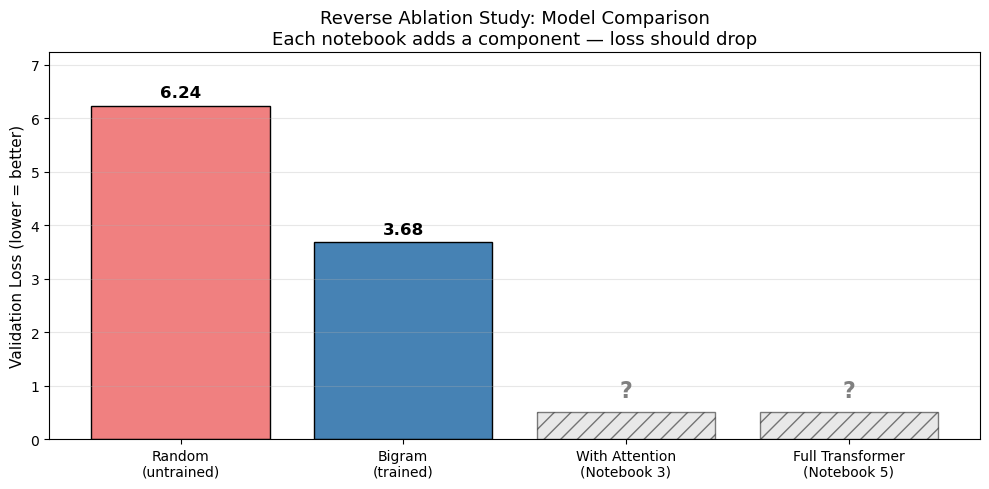

Random -> Bigram: 6.24 -> 3.68 (41% reduction)

The bigram model learned token-level statistics, but it hit a ceiling.
To go lower, we need CONTEXT — the ability to look at previous tokens.
That's exactly what self-attention provides in Notebook 3.


In [19]:
# Final summary visualization

fig, ax = plt.subplots(figsize=(10, 5))

models = ['Random\n(untrained)', 'Bigram\n(trained)', 'With Attention\n(Notebook 3)', 'Full Transformer\n(Notebook 5)']
losses = [math.log(tokenizer.vocab_size), eval_losses[-1][2], None, None]
colors_bar = ['lightcoral', 'steelblue', 'lightgray', 'lightgray']
hatches = ['', '', '//', '//']

for i, (model_name, loss_val, color, hatch) in enumerate(zip(models, losses, colors_bar, hatches)):
    if loss_val is not None:
        bar = ax.bar(i, loss_val, color=color, edgecolor='black', linewidth=1, hatch=hatch)
        ax.text(i, loss_val + 0.1, f'{loss_val:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    else:
        bar = ax.bar(i, 0.5, color=color, edgecolor='black', linewidth=1, hatch=hatch, alpha=0.5)
        ax.text(i, 0.7, '?', ha='center', va='bottom', fontsize=16, fontweight='bold', color='gray')

ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, fontsize=10)
ax.set_ylabel('Validation Loss (lower = better)', fontsize=11)
ax.set_title('Reverse Ablation Study: Model Comparison\n'
             'Each notebook adds a component — loss should drop', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(l for l in losses if l is not None) + 1)

plt.tight_layout()
plt.show()

improvement = (1 - eval_losses[-1][2] / math.log(tokenizer.vocab_size)) * 100
print(f"Random -> Bigram: {math.log(tokenizer.vocab_size):.2f} -> {eval_losses[-1][2]:.2f} ({improvement:.0f}% reduction)")
print(f"\nThe bigram model learned token-level statistics, but it hit a ceiling.")
print(f"To go lower, we need CONTEXT — the ability to look at previous tokens.")
print(f"That's exactly what self-attention provides in Notebook 3.")

## Summary

### What We Built

A **bigram language model** — the simplest possible neural LM. The entire model is a single `512 x 512` embedding table (262K parameters). Given the current token, it looks up a row of the table and uses it as logits to predict the next token.

### The Embedding Space Perspective

| Aspect | Bigram Model | What Attention Will Add (Notebook 3) |
|---|---|---|
| **Representation** | Each token = 1 fixed vector (its row in the table) | Each token = context-dependent vector (changes based on neighbors) |
| **Prediction** | Same prediction regardless of context | Prediction adapts to what came before |
| **Information flow** | None — tokens are processed independently | Tokens "talk to" each other via attention |
| **What it learns** | Static transition probabilities (Markov chain) | Dynamic, context-sensitive patterns |
| **Limitation** | Can't distinguish "to **be**" from "will **be**" | Can use context to make different predictions |

### Key Insight

The bigram model proves that **token-level statistics alone** (which token follows which) capture some structure — the loss drops from 6.24 to ~4.x. But to generate coherent text, the model needs to **compose information across positions**. That requires a mechanism for tokens to communicate with each other.

That mechanism is **self-attention**, and it's the single biggest improvement in the entire ablation study.

### Next: Notebook 3

We add self-attention: instead of each token living in isolation, tokens will be able to look at previous tokens and adjust their representations. The embedding for `be` will be different depending on whether `to` or `will` came before it. This is the key breakthrough that makes transformers work.